In [53]:
import numpy as np

import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
import matplotlib as matplotlib

%matplotlib inline
from matplotlib.patches import Ellipse

import matplotlib.patches as mpatches
from scipy.optimize import brentq

from matplotlib import ticker

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## order of mag exploration for arrokoth saltation paper

Figures: 
'codot_var.png', 'sr.png' are made here
also 'splash_Da.png' and 'Arr.png'

Crater scaling parameters and table of values here. 

In [108]:
M_J = 2e27 # kg   # mass of jupiter
Msol = 1.98847e30 # kg   # mass of sun 
AU = 1.495978707e11 # m   astronomical unit
k_B = 1.380649E-23 #J⋅K−  Boltzmann constant mks
G = 6.67430E-11 # N m2 kg−2 gravitational constant mks
m_p = 1.67262192369E-27 # kg mass of proton
mgamma = 1.0  # adiabatic index for a diatomic gas setting it to be 1 because referee is an asshole 
m_H2 = 2*m_p  # hydrogen molecule mass
barm = m_p*2.3 # some extra molecular mass to take into account helium 
year = 365.25*24*60*60  # in s
sigma_SB = 5.670367E-8 # W m−2 K−4  Stephan Boltzmann constant 
Lsol = 3.828E26 # W. 
amu = 1.660537e-27 # atomic mass unit

m_Arr = 7.485E14 #kg  mass of Arrokoth 
D_Arr = 18.26*1e3 #km to m volume equiv diameter
R_Arr = D_Arr/2 # vol equiv radius
Vol_Arr = np.pi*4.0/3.0 * R_Arr**3
rho_Arr = m_Arr/Vol_Arr   # density?
V_esc = np.sqrt(2*G*m_Arr/R_Arr)  #m/s
g_Arr = G*m_Arr/R_Arr**2  # m/s^2  # g propto R

sigma_H2 = 2.0E-15/1e4 # cm2 to m2 molecular hydrogen cross section 

# ice cohesion surface energy per unit area 
gamma_cohesion = 0.244 # J m-2 Gundlach+Blum 2015 for ices
B_co = 8.74 # exponent for asperities 
# relevant for roll friction 
xi_crit = 0.2e-9 # nm 

rho_a= 1e3 #mean density of a planetesimal kg/m^3 !!!!!! notice this!!!!!!!
# mass in kg of a body with density rho_a and diameter 1km
rho_1000 = 1e3  #kg m-3

# D_a in m, rho_a in kg m-3
def get_ga(D_a,rho_a):
    R_a = D_a/2 # radius
    M_a = np.pi*(4./3)*rho_a*R_a**3  #Mass
    v_a = np.sqrt(2*G*M_a/R_a) # grav velocity 
    g_a = G*M_a/R_a**2
    return g_a  # in m/s^2

# D_a in m, rho_a in kg m-3
def get_va(D_a,rho_a):
    R_a = D_a/2 # radius
    M_a = np.pi*(4./3)*rho_a*R_a**3  #Mass
    v_a = np.sqrt(G*M_a/R_a) # grav velocity 
    g_a = G*M_a/R_a**2
    return v_a  # in m/s


# get bondi time  (as defined by Lambrechts+10
def get_tB(D_a,rho_a,u):
    R_a = D_a/2 # radius
    M_a = np.pi*(4./3)*rho_a*R_a**3  #Mass
    tB = G*M_a/u**3
    return tB
    

D1km = 1e3; # diameter 1km asteroid or planetesimal 
g_1km = get_ga(D1km,rho_1000)
v_1km = get_va(D1km,rho_1000)  #grav vel 
D10km = 1e4  #D_a = 10km
g_10km = get_ga(D10km,rho_1000)
v_10km = get_va(D10km,rho_1000)  #grav vel 
D100km = 1e5 #D_a = 100km
g_100km = get_ga(D100km,rho_1000)
v_100km = get_va(D100km,rho_1000)  #grav vel 

R1km = D1km/2
M_1km = np.pi*(4./3)*rho_a*R1km**3
#g_1km = G*M_1km/R1km**2
Omega_1km =np.sqrt(G*M_1km/R1km**3)  #only depends on density 

R10km = D10km/2
M_10km = np.pi*(4./3)*rho_a*R10km**3

R100km = D100km/2
M_100km = np.pi*(4./3)*rho_a*R100km**3

#print('g_Arr {:.2e} m/s2'.format(g_Arr))
#print('rho_Arr {:.2e} kg m-3'.format(rho_Arr))
#print('g_1km {:.2e} m/s2'.format(g_1km))
#print('g_10km {:.2e} m/s2'.format(g_10km))
#print('v_1km es {:.2f} m/s'.format(v_1km*np.sqrt(2)))
#print('v_10km es {:.2f} m/s'.format(v_10km*np.sqrt(2)))
#print('v_100km es {:.2f} m/s'.format(v_100km*np.sqrt(2)))
#print('Om_10km  {:.2e} s-1'.format(Omega_1km))


theta_d = 0.05  # aspect ratio 
Lstar = Lsol*5./7. # early sun correction 
T_1AU = (Lstar/(4*np.pi*sigma_SB*AU**2) *theta_d + 10.0**4)**0.25
print('T_1AU = {:.0f} K'.format(T_1AU))
# inspired by Lenz + 2020

T_1AU = 171 K


In [4]:
class planet:
    def __init__(self, g_a, P_g, T_g):
        self.g_a = g_a  # grav accel mks
        self.P_g = P_g  # pressure Pa
        self.T_g = T_g  # temp K
        self.c_g = 0     # sound speed, is the actual sound speed   m/s
        self.lambda_g = 0  # mean free path m
        self.rho_g = 0   # gas density kg/m^3
        self.nu_g = 0   # kin viscosity  m^2/s
        self.Ma = 0  # Mach number 
        self.rho_s = 0   # particle density kg/m^3
        self.mgamma =1.4  # adiabatic index 
        
# from Table S1 Gunn+22       
Earth = planet(9.8 ,102e3  ,295.0); 
Earth.c_g = 344.0; Earth.lambda_g = 0.0655e-6; Earth.rho_g = 1.2; Earth.nu_g = 15.3*1e-6; Earth.Ma = 0.007
Earth.rho_s = 2.5e3; Earth.mgamma = 1.4

Mars  = planet(3.73,0.625e3,204.);  
Mars.c_g  = 224.0; Mars.lambda_g  = 4.43e-6;   Mars.rho_g  = 0.018; Mars.nu_g = 737e-6; Mars.Ma = 0.01
Mars.rho_s = 2.8e3; Mars.mgamma = 1.3 

Pluto = planet(0.62,0.00105e3,46.); 
Pluto.c_g = 141.0; Pluto.lambda_g = 439e-6;    Pluto.rho_g = 0.000078; Pluto.nu_g = 41800e-6; Pluto.Ma = 0.1
Pluto.rho_s = 0.5e3; Pluto.mgamma = 1.5


In [47]:
# disk model
class dmodel:
    def __init__(self, name): 
        self.name = name
        if (name == 'M'):
            self.g_T = 170.  # T value at 1AU
            self.g_Sigma =3430.0   # Sigma value at 10 AU
        self.g_T = 170.
        self.g_Sigma =3430.0 
        self.redux = 1.0  # how much to reduce headwind in some cases!
        
Mmodel = dmodel('M')
#Mmodel.g_T = 100 can be changed if you want to!
print(Mmodel.g_T)
print(Mmodel.name)

170.0
M


In [66]:
#f_p_D = 0.5  # ratio of solids that are gone compared to what is left in planets for Desch model
# other required globals: k_B, AU, G, Msol, mgamma, barm, gamma_cohesion, xi_crit, B_co, alpha_g

# globals: AU,k_B, barm, G, Msol, sigma_H2

# returns mass/area in kg/m^2 for various disk models, r is radius from Sun in m
def Sig_g(r,model): # r in m returns sigma in kg/m^2
    #if (model.name =='D'):  # Desch model 
    #    print('Desch problem!')
    #    return 3430.0*(f_p_D/0.5)**-1 * (r/(10*AU))**-2.168  # Desch (2007)'s surface density
    #if (model.name =='M'): # like the Desch model but with a different exponent, our adopted model
    return model.g_Sigma * (r/(10*AU))**-1.5

    return 0

# r in m, returns gas density in midplane of disk in kg/m^3
def rho_midplane_g(r,model):
    #if (model.name =='D'): # Desch's midplane gas density
    #    return 1.93e-8 * (f_p_D/0.5)**-1 * (r/(10*AU))**-3.4537 
    #if (model.name =='M'):  # like Desch model but with different exponents
    hdisk = h_g(r,model)
    Sigg = Sig_g(r,model)
    rho_g = Sigg/(hdisk*np.sqrt(2.*np.pi))
    return rho_g
   
    #return 0

# disk Temperature in K, r in m
def T_g(r,model):
    #if (model.name =='D'):
    #    return 150.0*(r/AU)**-0.429 # Desch's 
    #if (model.name =='M'):
    return model.g_T*(r/AU)**-0.5    # similar to Desch's model but with different exp.
    
# returns isothermal sound speed in m/s
# r is orbital radius in m 
# barm is mean molecular mass in kg (something times m_p)
def c_g(r,model):
    kT = T_g(r,model)*k_B 
    return np.sqrt(kT/barm)  # sound speed in m/s

# returns thermal velocity (mean of speed using maxwell Boltzman velocity disn.)
def v_thermal(r,model):
    cs = c_g(r,model)
    return cs*np.sqrt(8.0/np.pi)
     
# compute eta gas pressure parameter 
def eta_g(r,model):
    cs = c_g(r,model)  # sound speed 
    v_K = np.sqrt(G*Msol/r)  # Keplerian velocity
    ratio = (cs/v_K)**2
    e_exp=4.0  # compute |d ln p/d ln r|
    if (model.name =='D'):  # rho is -3.5 about and c_s^2 is about -0.5, is close to 4
        e_exp = 4. 
    if (model.name =='M'):  # rho goes as Sigma/h c_s^2 = -1.5 x Om * c_s = -1.5 + -1.5 -0.25 = -3.25 = -11/4
        e_exp = 3.25
    
    x = 0.5*ratio*e_exp    # formula for eta
    return x

# return headwind velocity 
def u_headwind(r,model): # r in m
    eta = eta_g(r,model)
    v_K = np.sqrt(G*Msol/r)  # in m/s
    u = eta*v_K
    return u  # returns headwind velocity in m/s

# chiang and youdin 2010 scale height 
#def h_CY(r):
#    return 0.022*r*(r/AU)**(2.0/7.0)  #their eqn. 4

# pressure in Pa in midplnae
def pressure_g(r,model):
    rho = rho_midplane_g(r,model)
    cs = c_g(r,model)
    p = rho*cs**2 #/ mgamma
    return p

# return disk scale height in m
def h_g(r,model):  
    cs = c_g(r,model)  # in m/s sound speed 
    om_K = np.sqrt(G*Msol)*r**-1.5  # in 1/s angular rotation rate for orbit
    h_disk = cs/om_K # scale height in m from hyrdostatic equm
    return h_disk

# compute mean free path in gas in midplane (in m)
def mfp_midplane(r,model):
    rho_g = rho_midplane_g(r,model) # midplane density 
    n_g = rho_g/barm  # number density in gas 
    mfp = 1./(np.sqrt(2.)*n_g*sigma_H2)   # mean free path 
    return mfp

# compute viscosity in gas 
def visc_nu_g(r,model):
    #cs = c_g(r,model)  # in m/s isothermal sound speed 
    vth = v_thermal(r,model)
    mfp = mfp_midplane(r,model)
    nu = 0.5*mfp*vth  # from Vincenti book 1986 
    return nu  # 
    
# compute a stopping time in s at radius r (in m) for particle with radius s (in m)
# here rho_s is particle density in kg m-3
# only print regime if pstuff ==1
def t_stop(r,model,rho_s,s,pstuff):
    #cs = c_g(r,model)  # isothermal sound speed
    vth = v_thermal(r,model)   # thermal velocity 
    rho_g = rho_midplane_g(r,model) # midplane density 
    #n_g = rho_g/barm  #number density in gas 
    mfp =  mfp_midplane(r,model)  # mean free path 
    ts_E = (rho_s/rho_g)*(s/vth)  # Epstein regime 
    ts_S = ts_E * (4.0/9.0)*(s/mfp)  #Stokes regime
    if (s > (9.0/4.0)*mfp):  # Stokes regime
        ts = ts_S
        if (pstuff ==1):
            print('Stokes regime',mfp)
    else:
        if (pstuff ==1):
            print('Epstein regime')
        ts = ts_E
    return ts

# compute Stokes number at radius r for particle with radius s in m 
# here rho_s is particle density in kg m-3
def Stokes_no(r,model,rho_s,s,pstuff):
    ts = t_stop(r,model,rho_s,s,pstuff)
    om_K = np.sqrt(G*Msol)*r**-1.5  # in 1/s angular rotation rate for orbit
    St = ts*om_K
    return St

# compute grain size s in m given Stokes number
def s_St(r,model,St,rho_s,pstuff):
    om_K = np.sqrt(G*Msol)*r**-1.5
    ts = St/om_K
    vth = v_thermal(r,model)   # thermal velocity 
    #cs = c_g(r,model)  # in m/s iso-thermal sound speed 
    rho_mp = rho_midplane_g(r,model)
    mfp =  mfp_midplane(r,model)  # mean free path 
    s_E = ts*vth *rho_mp/rho_s  # size in Epstein regime
    if (s_E < (9.0/4.0)*mfp):  # Epstein regime
        if (pstuff ==1):
            print('Epstein')
        return s_E
    else:
        s2 = s_E*mfp* 9./4. 
        s_S = np.sqrt(s2)
        if (pstuff ==1):
            print('Stokes')
        return s_S  # Stokes regime 
    
# compute grain size in m given t_stop = Omega_a^-1
def s_ga(r,model,Omega_a,rho_s,pstuff):
    ts = Omega_a**-1
    #cs = c_g(r,model)  # in m/s iso-thermal sound speed 
    vth = v_thermal(r,model)   # thermal velocity 
    rho_mp = rho_midplane_g(r,model)
    mfp =  mfp_midplane(r,model)  # mean free path 
    s_E = ts*vth *rho_mp/rho_s  # size in Epstein regime
    if (s_E < (9.0/4.0)*mfp):  # Epstein regime
        if (pstuff ==1):
            print('Epstein')
        return s_E
    else:
        s2 = s_E*mfp* 9./4. 
        s_S = np.sqrt(s2)
        if (pstuff ==1):
            print('Stokes')
        return s_S  # Stokes regime 
    
# compute grain size s in m  that has stopping time equal to crossing time 
# here using u_hw headwind velocity
# and using D_a for diameter of asteroid and rho_s for grain density
def s_sc(r,model,D_a,rho_s,pstuff):
    u_hw = u_headwind(r,model)
    rho_g =rho_midplane_g(r,model)
    mfp =  mfp_midplane(r,model)  # mean free path 
    vth = v_thermal(r,model)   # thermal velocity 
    #cs=c_g(r,model) 
    s_E = rho_g*vth*D_a/(rho_s*u_hw)   # for Epstein regime
    if (s_E < (9.0/4.0)*mfp):  # Epstein regime
        if (pstuff ==1):
            print('Epstein')
        return s_E
    else:
        s2 = s_E*mfp* 9./4. 
        s_S = np.sqrt(s2)
        if (pstuff ==1):
            print('Stokes')
        return s_S

# compute diameter of asteroid that is eroded by an impact at velocity u_hw
# here rho_a is asteroid density, rho_s is projectile density  
def D_erode(r,model,rho_a,rho_s):
    u_hw = u_headwind(r,model)*model.redux  # notice redux here!!!! 
    pi_4 = rho_a/rho_s
    D_er = u_hw/np.sqrt(G*rho_a*2*np.pi/3)*pi_4**(-0.167)  
    # factor of 0.0611 from crater scaling  and exponent of pi_4 from crater scaling
    k=0.3; mu=0.4; C_1 = 0.55; nu=0.4;   # for impacts scaling
    zfac = C_1*( 3.*k/(4. *np.pi))**(1./(3.*mu)) # = 0.0611
    D_er *= zfac
    return D_er

#k=0.3; mu=0.4; C_1 = 0.55; nu=0.4; H_2 =0.4;  # for impacts scaling
#z = C_1*( 3.*k/(4. *np.pi))**(1./(3.*mu)) here is where the 0.0611 is from
# the -0.17 = (1 - 3*nu)/(3*mu)

# this is the dimensionless Gtilde thing which is used in streaming inst calculations
# G tilde = 0.05 gives Q=32  I think  Toomre Q = 1.6 /Gtilde
def G_tilde(r,model):
    rho_mp = rho_midplane_g(r,model)
    om_K = np.sqrt(G*Msol/r**3)
    Gt = 4*np.pi*G*rho_mp/om_K**2
    return Gt



In [7]:
# more parameters to set
alpha_g = 1e-2  # accretion!
rho_s = 500.0 # density of grains kg/m^3
Y_a = 500.0 # Pa material strength of regolith 
#model = 'M'

In [109]:
# these routines use root finding to find parameter that cover different regimes
#B_co is global

# find Drag acceleration from disk all possible regimes , using s particle size
# and assuming that velocity is from headwind
def get_a_D(r,model,rho_s,s):
    rho_g =rho_midplane_g(r,model)
    mfp =  mfp_midplane(r,model)  # mean free path 
    vth = v_thermal(r,model)   # thermal velocity 
    #cs=c_g(r,model) 
    u_hw = u_headwind(r,model)*model.redux
    nu_g = visc_nu_g(r,model) 
    Re_s = s* u_hw/nu_g
    Kn_s = mfp/s  
    Kn94 = 9.0*Kn_s/4.0
    a_D = rho_g*vth *u_hw/ (rho_s*s) * Kn94/(1.0 + Kn94) * (1 + Re_s*3.0/16)
    return a_D   # return F_D/m_s

# this is a function we want to find the root for to get s_max 
def f_a_D(s,r,model,rho_s,g_a):
    a_D = get_a_D(r,model,rho_s,s)
    return a_D - g_a   

# this is a function we want to find the root to get s_pull
def f_pull(s,r,model,rho_s,gamma_cohesion):
    m_s = 4.0*np.pi*rho_s*s**3/3.0
    F_D = m_s* get_a_D(r,model,rho_s,s)  # drag force
    coh = np.pi*gamma_cohesion*np.exp(-B_co)*s  #cohesion force
    return F_D-coh 
  
# should give us s_max max saltation particle all regimes!
def get_s_max(r,model,rho_s,g_a):
    a = 1e-10; b = 1e1  # range to try!
    xa = f_a_D(a,r,model,rho_s,g_a)
    xb = f_a_D(b,r,model,rho_s,g_a)
    if (xa*xb >0 ):
        print(xa,xb)
        return -1
    else: 
        s_max = brentq(f_a_D, a, b, args=(r,model,rho_s,g_a))  # find root
        return s_max

def get_KnRe(r, model, rho_s,s):
    rho_g =rho_midplane_g(r,model)
    mfp =  mfp_midplane(r,model)  # mean free path 
    #cs=c_g(r,model) 
    u_hw = u_headwind(r,model)*model.redux
    nu_g = visc_nu_g(r,model) 
    Re_s = s* u_hw/nu_g
    Kn_s = mfp/s  
    print('Kn={:.2e} Re={:.2e}'.format(Kn_s,Re_s))
    return Kn_s,Re_s

def get_s_pull(r, model, rho_s,gamma_cohesion):
    a = 1e-8; b = 1e1  # range to try!
    xa = f_pull(a,r,model,rho_s,gamma_cohesion)
    xb = f_pull(b,r,model,rho_s,gamma_cohesion)
    if (xa*xb >0 ):
        print(xa,xb)
        return -1
    else:
        s_pull = brentq(f_pull, a, b, args=(r,model,rho_s,gamma_cohesion))  # find root
        #print(s_pull)
        return s_pull
    
def a_D_planet(planet,s):
    uwind = planet.Ma*planet.c_g  # wind velocity 
    Re_s = s* uwind/planet.nu_g   # Reynolds number 
    Kn_s = planet.lambda_g/s      # Knudsen number 
    Kn94 = 9.0*Kn_s/4.0
    c_iso = np.sqrt(planet.P_g/planet.rho_g)  #isothermal sound speed 
    v_th  = np.sqrt(8/np.pi)*c_iso  # thermal velocity 
    a_D = planet.rho_g*v_th *uwind /(planet.rho_s*s) * Kn94/(1.0 + Kn94) * (1.0 + Re_s*3.0/16.)
    return a_D

def f_a_D_planet(s,planet):
    a_D = a_D_planet(planet,s)
    return a_D - planet.g_a  

def get_s_max_planet(planet):
    a = 1e-6; b = 1e1  # range to try!
    xa = f_a_D_planet(a,planet)  # bracket root 
    xb = f_a_D_planet(b,planet)
    #print(xa,xb)
    s_max = brentq(f_a_D_planet, a, b, args=(planet))  # find root
    return s_max

# this is a function we want to find the root to get s_pull
def f_pull_planet(s,planet,gamma_cohesion):
    m_s = 4.0*np.pi*planet.rho_s*s**3/3.0
    F_D = m_s* a_D_planet(planet,s)  # drag force
    coh = np.pi*gamma_cohesion*np.exp(-B_co)*s  #cohesion force
    return F_D-coh 

def get_s_pull_planet(planet,gamma_cohesion):
    a = 1e-10; b = 1e1  # range to try!
    xa = f_pull_planet(a,planet,gamma_cohesion)  #bracket root
    xb = f_pull_planet(b,planet,gamma_cohesion)
    if (xa*xb >0 ):
        print(xa,xb)
        return -1
    else:
        s_pull = brentq(f_pull_planet, a, b, args=(planet,gamma_cohesion))  # find root
        return s_pull

# uses generalized a_D to compute t_stop (using headwind!)
def get_t_stop(r,model,rho_s,s):
    a_D = get_a_D(r,model,rho_s,s)  # this is F_D/m_s ,    a_D/u_hw is m/s^2 / m/s is in units of 1/t
    #m_s = 4.0*np.pi*rho_s*s**3/3
    u_hw = u_headwind(r,model)*model.redux
    t_s = u_hw/a_D
    return t_s   # return F_D/(m_s u_hw)

# this is a function we want to find the root to get s for a particular tstop value 
def f_t_stop(s,r,model,rho_s,t_s_val):
    t_s = get_t_stop(r,model,rho_s,s)
    return t_s - t_s_val    

# return particle size that has a particular tstop value ts 
def get_s_tstop(r,model,rho_s,t_s_val):
    a = 1e-10; b = 10  # range to try!
    xa = f_t_stop(a,r,model,rho_s,t_s_val)   # bracket root
    xb = f_t_stop(b,r,model,rho_s,t_s_val)
    if (xa*xb >0 ):
        #print(xa,xb)
        return -1
    else: 
        s_ts = brentq(f_t_stop, a, b, args=(r,model,rho_s,t_s_val))  # find root
        return s_ts
    
# tests    
#g_a = g_1km  
#r = 1*AU
#s_max = get_s_max(r,model,rho_s,g_a) 
#print(s_max)
#r = 10*AU
#s_pull = get_s_pull(r, model, rho_s,gamma_cohesion) 
#print(s_pull)

In [110]:
# compute some quantities for planets, needed for figure below 
spull_E = get_s_pull_planet(Earth,gamma_cohesion/10); #print(spull_E)
spull_M = get_s_pull_planet(Mars,gamma_cohesion/10); #print(spull_M)
spull_P = get_s_pull_planet(Pluto,gamma_cohesion); #print(spull_P)
print('s_pull E M P {:.2e} {:.2e} {:.2e}'.format(spull_E,spull_M,spull_P))
smax_E = get_s_max_planet(Earth); #print(smax_E)
smax_M = get_s_max_planet(Mars);  #print(smax_M)
smax_P = get_s_max_planet(Pluto); # print(smax_P)
print('s_max E M P {:.2e} {:.2e} {:.2e}'.format(smax_E,smax_M,smax_P))

s_pull E M P 2.21e-09 2.50e-07 1.66e-04
s_max E M P 2.69e-04 1.05e-04 4.61e-04


-1.2268908478011426e-12 -0.00010942695031921647
-1.2268908485059552e-12 -0.0007625415681106985
-1.2268908487899674e-12 -0.001037208012356631


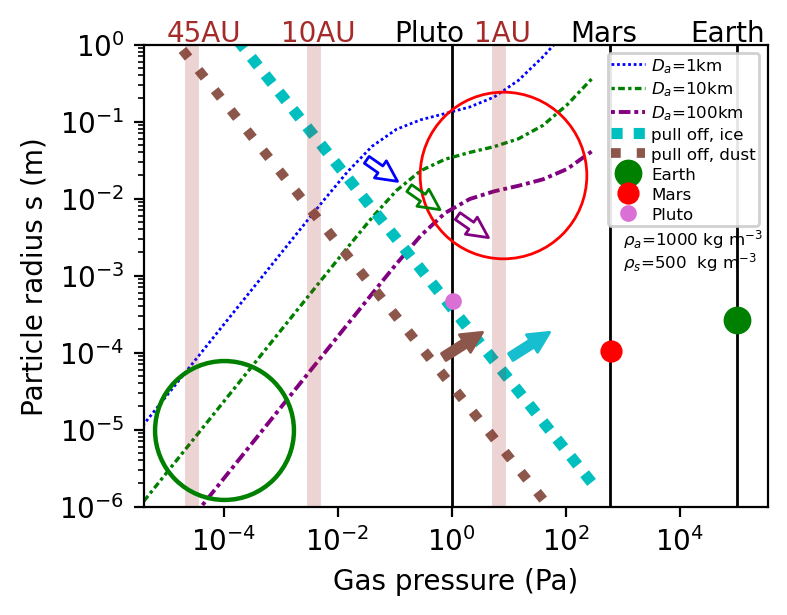

In [168]:

# needed for figure below 
rlinAU = np.logspace(-0.5,2,20)  # orbital radius
rlin = rlinAU*AU
Plin = pressure_g(rlin,Mmodel)

rho_ss = 500.   # grain density
rho_aa = 1000.  # planetesimal density mks

# compute smax, saltation limits, for different asteroids at different radii/pressures
# uses g_as! 
s_max_1 = rlin*0; s_max_10 = rlin*0; s_max_100 = rlin*0
for i in range(len(rlin)):
    s_max_1[i]   = get_s_max(rlin[i],Mmodel,rho_ss,get_ga(1e3,rho_aa)) # D_a = 1km
    s_max_10[i]  = get_s_max(rlin[i],Mmodel,rho_ss,get_ga(1e4,rho_aa)) # D_a = 10km
    s_max_100[i] = get_s_max(rlin[i],Mmodel,rho_ss,get_ga(1e5,rho_aa)) # D_a = 100km

# compute spull, cohesion limits for dust and ice at different radii/pressures
s_pull_dust = rlin*0 ;    s_pull_ice = rlin*0
for i in range(len(rlin)):
    s_pull_ice[i] = get_s_pull(rlin[i], Mmodel, rho_ss,gamma_cohesion) 
    s_pull_dust[i]= get_s_pull(rlin[i], Mmodel, rho_ss,gamma_cohesion/10) 
    
# only prints stuff out if root finding won't work (bad bracketing)

#Saltation limits wide pressure ranges, make nice figure 
fig,ax =plt.subplots(1,1,figsize=(4,3),dpi=200,facecolor='white')
plt.subplots_adjust(bottom=0.18, top=0.95,left=0.2,right=0.98)

sfac = 1
ax.set_yscale('log')
ax.set_xscale('log')

#saltation limits 
ii = s_max_1 > 0 
ax.plot(Plin[ii],s_max_1[ii]*sfac,label=r'$D_a$=1km',color='blue',lw=1.0,ls = (0,(1,1,1,1)),zorder=2)
ii = s_max_10 > 0 
ax.plot(Plin[ii],s_max_10[ii]*sfac,label=r'$D_a$=10km',color='green',lw=1.2,ls = (0,(1,1,2,1)),zorder=2)
ii = s_max_100 > 0 
ax.plot(Plin[ii],s_max_100[ii]*sfac,label=r'$D_a$=100km',color='purple',lw=1.4,ls = (0,(1,1,3,1)),zorder=2)

# cohesion limits
ii = s_pull_ice > 0 
ax.plot(Plin[ii],s_pull_ice[ii]*sfac,'c',lw=4,label='pull off, ice',zorder=2,ls = (0,(1,1,1,1)))
ii = s_pull_dust > 0 
ax.plot(Plin[ii],s_pull_dust[ii]*sfac,':',lw=3.5,label='pull off, dust',zorder=2,color='tab:brown')

# arrows
# x_tail,y_tail then x_head, y_head
# arrows for saltation 
x0=0.027; y0=35.0*sfac/1e3; dax = 5.; day=1/2.3
arrow = mpatches.FancyArrowPatch((x0, y0), (x0*dax, y0*day),mutation_scale=15,ec='blue',fc='none',zorder=3)
ax.add_patch(arrow)
x0=0.15; y0=15.0*sfac/1e3; dax = 5.; day=1/2.3
arrow2 = mpatches.FancyArrowPatch((x0, y0), (x0*dax, y0*day),mutation_scale=15,ec='green',fc='none',zorder=3)
ax.add_patch(arrow2)
x0=1.06; y0=6.5*sfac/1e3; dax = 5.; day=1/2.3
arrow3 = mpatches.FancyArrowPatch((x0, y0), (x0*dax, y0*day),mutation_scale=15,ec='purple',fc='none',zorder=3)
ax.add_patch(arrow3)
# arrows for cohesion 
x0=9.; y0=0.08*sfac/1e3; dax = 7.; day=2.5
arrow4 = mpatches.FancyArrowPatch((x0, y0), (x0*dax, y0*day),mutation_scale=15,ec='tab:cyan',fc='tab:cyan',zorder=3)
ax.add_patch(arrow4)
x0=0.6; y0=0.08*sfac/1e3; dax = 7.; day=2.5
arrow5 = mpatches.FancyArrowPatch((x0, y0), (x0*dax, y0*day),mutation_scale=15,ec='tab:brown',fc='tab:brown',zorder=3)
ax.add_patch(arrow5)

# planets
ax.plot(Earth.P_g,smax_E*sfac,'go',label='Earth',ms=9)
ax.plot(Mars.P_g,smax_M*sfac,'ro',label='Mars',ms=7)
ax.plot(Pluto.P_g,smax_P*sfac,'o',label='Pluto',color='orchid',ms=5)
#ax.plot(Earth.P_g,spull_E*1e3,'gs',label='Earth')
#ax.plot(Mars.P_g,spull_M*1e3,'rs',label='Mars')
#ax.plot(Pluto.P_g,spull_P*1e3,'s',label='Pluto',color='magenta')

ax.set_ylim([1e-3*sfac/1e3,1e3*sfac/1e3])
ax.set_xlim(left=0.4e-5)

smin, smax = ax.get_ylim()
p_1 = pressure_g(1*AU,Mmodel)
p_10 = pressure_g(10*AU,Mmodel)
p_45 = pressure_g(45*AU,Mmodel)
# disk vertical lines
ax.plot([p_45,p_45],[smin,smax],'-',lw=5,alpha=0.2,color='brown')
ax.text(1e-5,1.1e3*sfac/1e3,'45AU',color='brown')
ax.plot([p_10,p_10],[smin,smax],'-',lw=5,alpha=0.2,color='brown')
ax.text(1e-3,1.1e3*sfac/1e3,'10AU',color='brown')
ax.plot([p_1,p_1],[smin,smax],'-',lw=5,alpha=0.2,color='brown')
ax.text(2.5e-0,1.1e3*sfac/1e3,'1AU',color='brown')

# planet vertical lines
ax.plot([1e5,1e5],[smin,smax],'k-',lw=1,zorder=1)
ax.text(1.5e4,1.1e3*sfac/1e3,'Earth')
ax.plot([0.6e3,0.6e3],[smin,smax],'k-',lw=1,zorder=1)
ax.text(1.2e2,1.1e3*sfac/1e3,'Mars')
ax.plot([1.0,1e0],[smin,smax],'k-',lw=1,zorder=1)
ax.text(0.1,1.1e3*sfac/1e3,'Pluto')

ax.legend(loc='upper right',fontsize=6,borderpad=0.2,handletextpad=0.4,labelspacing=0.3,\
         framealpha=0.9)

ax.set_xlabel('Gas pressure (Pa)')
if (sfac==1e3):
    ax.set_ylabel('Particle radius s (mm)')
if (sfac==1):
    ax.set_ylabel('Particle radius s (m)')
    
# circles
ax.plot(8,20*sfac/1e3,'o',mec='red',mew=1,ms=60,fillstyle='none')
ax.plot(1e-4,0.01*sfac/1e3,'o',mec='green',mew=1.6,ms=50,fillstyle='none')

# label densities mks
ax.text(1e3,1.5e-3*sfac,r'$\rho_s$=500  kg m$^{-3}$',ha='left',va='center',fontsize=6)
ax.text(1e3,3e-3*sfac,r'$\rho_a$=1000 kg m$^{-3}$',ha='left',va='center',fontsize=6)

plt.savefig('codot_var.png',dpi=200)
# stuff only printed out where root finding fails, so don't worry about it

In [229]:
# print values at a bunch of different radii for a table
rAU =np.array([1,3.2,10,45])
#model  = 'M'
pstring = 'Sigma_gas kg m-2 '
for i in range(len(rAU)):
    r = rAU[i]*AU  # radius in AU 
    sig = Sig_g(r,Mmodel)
    pstring += ' & {:.1e} '.format(sig)
pstring += '\\\\'
print(pstring)

pstring = 'rho_g kg m-3 '
for i in range(len(rAU)):
    r = rAU[i]*AU  # radius in AU 
    rho_g =rho_midplane_g(r,Mmodel)
    pstring += ' & {:.1e} '.format(rho_g)
pstring += '\\\\'
print(pstring)

pstring = 'cg m/s  '
for i in range(len(rAU)):
    r = rAU[i]*AU  # radius in AU 
    cs=c_g(r,Mmodel) 
    pstring += ' & {:.0f} '.format(cs)
pstring += '\\\\'
print(pstring)

pstring = 'h/r -  '
for i in range(len(rAU)):
    r = rAU[i]*AU  # radius in AU 
    hh=h_g(r,Mmodel) 
    aspect = hh/r
    pstring += ' & {:.3f} '.format(aspect)
pstring += '\\\\'
print(pstring)

pstring = 'Pg  Pa  '
for i in range(len(rAU)):
    r = rAU[i]*AU  # radius in AU 
    P_g = pressure_g(r,Mmodel)
    pstring += ' & {:.1e} '.format(P_g)
pstring += '\\\\'
print(pstring)

pstring = 'T K  '
for i in range(len(rAU)):
    r = rAU[i]*AU  # radius in AU 
    T = T_g(r,Mmodel)
    pstring += ' & {:.0f} '.format(T)
pstring += '\\\\'
print(pstring)

pstring = 'lambda_g m  '  # mean free path
for i in range(len(rAU)):
    r = rAU[i]*AU  # radius in AU 
    mfp  = mfp_midplane(r,Mmodel)
    #rho_g =rho_midplane_g(r,model)
    #n_g = rho_g/barm  #number density
    #mfp = 1./(n_g*sigma_H2)  #mean free path
    pstring += ' & {:.1e} '.format(mfp)
pstring += '\\\\'
print(pstring)

pstring = 'eta_g - '
for i in range(len(rAU)):
    r = rAU[i]*AU  # radius in AU 
    eta_M = eta_g(r,Mmodel)
    #u_hw = u_headwind(r,eta_M)
    pstring += ' & {:.1e} '.format(eta_M)
pstring += '\\\\'
print(pstring)

pstring = 'nu_g m^2 s-1 '
for i in range(len(rAU)):
    r = rAU[i]*AU  # radius in AU 
    nu_g = visc_nu_g(r,Mmodel)
    pstring += ' & {:.2f} '.format(nu_g)
pstring += '\\\\'
print(pstring)

pstring = 'u_hw m/s '  #headwind velocity
for i in range(len(rAU)):
    r = rAU[i]*AU  # radius in AU 
    #eta_M = eta_g(r,model)
    u_hw = u_headwind(r,Mmodel)
    pstring += ' & {:.1f} '.format(u_hw)
pstring += '\\\\'
print(pstring)

pstring = 'u_turb m/s '  #turbulent eddy velocity
for i in range(len(rAU)):
    r = rAU[i]*AU  # radius in AU 
    cs=c_g(r,Mmodel) 
    vt = np.sqrt(alpha_g)*cs 
    pstring += ' & {:.1f} '.format(vt)
pstring += '\\\\'
print(pstring)


# size of particle for stopping time of 3000s
pstring = 's (mm) for t_s = 3000 s ' 
for i in range(len(rAU)):
    r = rAU[i]*AU  # radius in AU 
    t_s_val = 3000.0;
    rho_ss= 500.
    ss = get_s_tstop(r,Mmodel,rho_ss,t_s_val) # get size of particle that has this particular stopping time
    pstring +=  ' & {:.1e} '.format(ss*1e3)
pstring += '\\\\'
print(pstring)

pstring = 'Re_hw -- '  # reynolds number
for i in range(len(rAU)):
    r = rAU[i]*AU  # radius in AU 
    nu_g=visc_nu_g(r,Mmodel)
    u_hw = u_headwind(r,Mmodel)  # no redux used!
    #cs=c_g(r,Mmodel) 
    #vt = np.sqrt(alpha_g)*cs 
    Re_hw = D10km*u_hw/nu_g
    pstring += ' & {:.1e} '.format(Re_hw)
pstring += '\\\\'
print(pstring)

pstring = 'Re_vt -- '
for i in range(len(rAU)):
    r = rAU[i]*AU  # radius in AU 
    nu_g=visc_nu_g(r,Mmodel)
    u_hw = u_headwind(r,Mmodel)  # no redux!
    cs=c_g(r,Mmodel) 
    vt = np.sqrt(alpha_g)*cs 
    Re_vt = D10km*vt/nu_g
    pstring += ' & {:.1e} '.format(Re_vt)
pstring += '\\\\'
print(pstring)

#Cohesion limits 

pstring = 's_pull ice (mm) '
for i in range(len(rAU)):
    r = rAU[i]*AU  # radius in AU 
    rho_ss= 500.
    s_pull_ice = get_s_pull(r, Mmodel, rho_ss,gamma_cohesion) 
    pstring += ' & {:.1e} '.format(s_pull_ice*1e3)
pstring += '\\\\'
print(pstring)

pstring = 's_dust ice (mm) '
for i in range(len(rAU)):
    r = rAU[i]*AU  # radius in AU 
    rho_ss= 500.
    s_pull_dust = get_s_pull(r, Mmodel, rho_ss,gamma_cohesion/10) 
    pstring += ' & {:.1e} '.format(s_pull_dust*1e3)
pstring += '\\\\'
print(pstring)

pstring = 'G tilde  '  #dimensionless parm, not put in table 1 but printed anyhow
for i in range(len(rAU)):
    r = rAU[i]*AU  # radius in AU 
    Gt = G_tilde(r,Mmodel)
    pstring += ' & {:.2f} '.format(Gt)
pstring += '\\\\'
print(pstring)

#globals:  D10km

pstring = 'tcross s (D10km)'  # crossing time for an asteroid D10km
for i in range(len(rAU)):
    r = rAU[i]*AU  # radius in AU 
    u_hw = u_headwind(r,Mmodel)  # no redux used
    #D1km=R1km*2
    tcross = D10km/u_hw
    pstring += ' & {:.1f} '.format(tcross)
pstring += '\\\\'
#print(pstring)   # not printed!


pstring = 'tB s '  # Bondi time for an asteroid D10km, not used currently 
for i in range(len(rAU)):
    r = rAU[i]*AU  # radius in AU 
    u_hw = u_headwind(r,Mmodel)  # no redux
    #D1km=R1km*2
    rho_a = 1e3
    tB = get_tB(D10km,rho_a,u_hw)
    pstring += ' & {:.4f} '.format(tB)
pstring += '\\\\'
#print(pstring)   # not printed 


# print table 1, disk properties, 4 different radii 
# all of this goes into Table 1 except Gtilde row 

Sigma_gas kg m-2  & 1.1e+05  & 1.9e+04  & 3.4e+03  & 3.6e+02 \\
rho_g kg m-3  & 1.1e-05  & 4.5e-07  & 2.0e-08  & 3.1e-10 \\
cg m/s   & 781  & 584  & 439  & 302 \\
h/r -   & 0.026  & 0.035  & 0.047  & 0.068 \\
Pg  Pa   & 6.7e+00  & 1.5e-01  & 3.8e-03  & 2.9e-05 \\
T K   & 170  & 95  & 54  & 25 \\
lambda_g m   & 1.2e-03  & 3.0e-02  & 6.9e-01  & 4.3e+01 \\
eta_g -  & 1.1e-03  & 2.0e-03  & 3.5e-03  & 7.5e-03 \\
nu_g m^2 s-1  & 0.77  & 14.08  & 243.02  & 10439.51 \\
u_hw m/s  & 33.3  & 33.3  & 33.3  & 33.3 \\
u_turb m/s  & 78.1  & 58.4  & 43.9  & 30.2 \\
s (mm) for t_s = 3000 s  & 1.5e+01  & 2.4e+00  & 8.2e-02  & 9.1e-04 \\
Re_hw --  & 4.3e+05  & 2.4e+04  & 1.4e+03  & 3.2e+01 \\
Re_vt --  & 1.0e+06  & 4.1e+04  & 1.8e+03  & 2.9e+01 \\
s_pull ice (mm)  & 6.5e-02  & 2.2e+00  & 6.7e+01  & 6.2e+03 \\
s_dust ice (mm)  & 6.4e-03  & 2.1e-01  & 6.4e+00  & 5.9e+02 \\
G tilde   & 0.23  & 0.31  & 0.41  & 0.60 \\


In [93]:
# now we print stuff that goes in equations in section 2:
r = 10*AU
rho_g =rho_midplane_g(r,Mmodel)
print('rho_g {:.1e} kg m-3'.format(rho_g))

mfp  = mfp_midplane(r,Mmodel)
print('lamdga_g {:.2f} m'.format(mfp))

u_hw = u_headwind(r,Mmodel)  # no redux!
print('u_hw {:.1f} m/s'.format(u_hw))

cs=c_g(r,Mmodel) 
Ma = u_hw/cs
print('Ma {:.2f} '.format(Ma))

vt = np.sqrt(alpha_g)*cs 
print('u turb {:.1f} m/s '.format(vt))

nu_g=visc_nu_g(r,Mmodel)
Re_hw = D10km*u_hw/nu_g
Re_vt = D10km*vt/nu_g
print('Re hw {:.0f} '.format(Re_hw))
print('Re vt {:.0f} '.format(Re_vt))

print('-----------------------')

tcross = D1km/u_hw  #global D1km used here 
print('tcross D1km {:.1f} s'.format(tcross))  # this is in section 3, \label{eqn:tcross}

rho_g 1.8e-08 kg m-3
lamdga_g 0.65 m
u_hw 38.3 m/s
Ma 0.08 
u turb 47.1 m/s 
Re hw 1575 
Re vt 1938 
-----------------------
tcross D1km 26.1 s


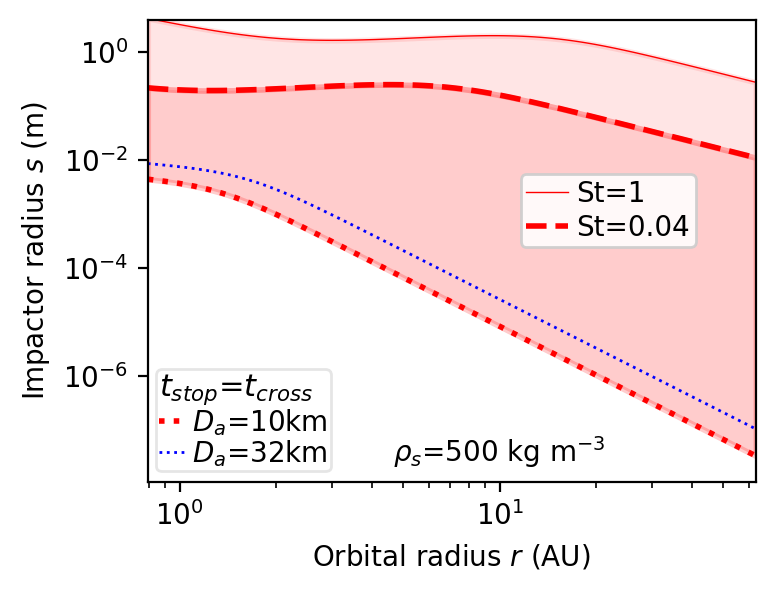

In [169]:
# We can make a size plot  vs r.  This goes into paper!
fig,ax =plt.subplots(1,1,figsize=(4,3),dpi=200,facecolor='white')
plt.subplots_adjust(bottom=0.18, top=0.95,left=0.22,right=0.98)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel(r'Impactor radius $s$ (m)')
ax.set_xlabel(r'Orbital radius $r$ (AU)')

rho_ss= 500. #  
rho_aa = 1e3

rlinAU = np.logspace(-0.1,1.8,100)  # in AU
ax.set_xlim([min(rlinAU),max(rlinAU)])
rlin = rlinAU*AU
ax.set_ylim([1.1e-8,4])

scval10 = rlin*0;  scval1 = rlin*0; scval31 = rlin*0; 
scval10_b = rlin*0;  scval1_b = rlin*0; 
Stval04 = rlin*0; Stval04_b = rlin*0; 
Stval1 = rlin*0; Stval1_b = rlin*0; 
tBval10 = rlin*0; tBval31 = rlin*0

u_hw = u_headwind(10*AU,Mmodel)  # no redux yet
for i in range(len(rlin)):
    #scval1[i]  = s_sc(rlin[i],model,D1km,rho_s,0)   # t_stop = tcross
    #scval10[i] = s_sc(rlin[i],model,D10km,rho_s,0) 
    #scval31[i] = s_sc(rlin[i],model,D10km*3.16,rho_s,0) 
    #scval45[i] = s_sc(45*AU,model,D1km,rho_s,0) 
    #Stval1[i] = s_St(rlin[i],model,1.0,rho_s,0)   # getting s for St = 1
    #Stval04[i] = s_St(rlin[i],model,0.04,rho_s,0)  # getting s for St = 0.04
    
    # ts= tcross 
    t_cross1 = D1km/u_hw;  t_cross10 = D10km/u_hw;  t_cross31 = D10km*3.16/u_hw
    scval10[i]  =  get_s_tstop(rlin[i],Mmodel,rho_ss,t_cross10)  # t_stop = tcross
    scval31[i]  =  get_s_tstop(rlin[i],Mmodel,rho_ss,t_cross31)  # t_stop = tcross
    scval10_b[i] = get_s_tstop(rlin[i],Mmodel,rho_ss/10,t_cross10)  
    
    om_K = np.sqrt(G*Msol/rlin[i]**3)
    Stval04[i] =  get_s_tstop(rlin[i],Mmodel,rho_ss,0.04/om_K)
    Stval04_b[i] =  get_s_tstop(rlin[i],Mmodel,rho_ss/10,0.04/om_K)  # lower density here 
    Stval1[i] =  get_s_tstop(rlin[i],Mmodel,rho_ss,1.0/om_K)
    Stval1_b[i] =  get_s_tstop(rlin[i],Mmodel,rho_ss/10,1.0/om_K)  # lower density here 
    
    # Bondi?
    tB_10 = G*1.3333*np.pi*rho_aa*(D10km/2)**3/u_hw**2;  
    tB_31 = G*1.3333*np.pi*rho_aa*(D10km*3.16/2)**3/u_hw**2;  
    tBval10[i] = get_s_tstop(rlin[i],Mmodel,rho_ss,tB_10)
    tBval31[i] = get_s_tstop(rlin[i],Mmodel,rho_ss,tB_31)
    

# plot St 1.0
STA1, = ax.plot(rlinAU,Stval1   ,'r-',label=r'St=1',lw=0.5) 
# plot St=0.04
STA04, = ax.plot(rlinAU,Stval04  ,'r--',label=r'St=0.04',lw=2)


first_legend = ax.legend(handles=[STA1,STA04],loc='lower left',fontsize=10,borderpad=0.2,borderaxespad=0.3,\
        handletextpad=0.3,labelspacing=0.2,\
         handlelength=1.5,framealpha=0.9,ncol=1,columnspacing=1,frameon=True,\
          bbox_to_anchor=(0.6, 0.49),alignment='left') #,title=r'$St$=0.04',title_fontsize=10,
ax.add_artist(first_legend)

SC10,=ax.plot(rlinAU,scval10,'r:',label=r'$D_a$=10km',lw=2)
SC31,=ax.plot(rlinAU,scval31,'b:',label=r'$D_a$=32km',lw=1)
ax.fill_between(rlinAU, scval10,Stval04, color='red', alpha=0.2,lw=2)   #pink fill

ax.fill_between(rlinAU, Stval1,Stval04, color='red', alpha=0.1,lw=2) 

rhos_string = r'$\rho_s$=500 kg m$^{-3}$'
ax.text(10,0.4e-7,rhos_string, fontsize=10,va='center',ha='center')

second_legend = ax.legend(handles=[SC10,SC31],loc='lower left',fontsize=10,borderpad=0.1,borderaxespad=0.2,\
        handletextpad=0.2,labelspacing=0.0,\
         handlelength=1.0,framealpha=0.5,ncol=1,columnspacing=1,frameon=True,\
          bbox_to_anchor=(0.005, 0.01),title=r'$t_{stop}$=$t_{cross}$',title_fontsize=11,alignment='left')


plt.savefig('sr.png',dpi=200)

In [105]:

# in order for equations in section 3 

# impacts crater scaling stuff 
print('for ejecta velocity relation:')
# parameters from House+Holsapple+2011
Y_a = 500.  #notice this!!!! Pa
k=0.3; mu=0.4; C_1 = 0.55; nu=0.4; H_2 =0.4;  # for impacts scaling
n_1 = 1.2 

# to find strength regime (equation in section 3.2)
u_0 = 40.  #hw velocity m/s   # scaling with pi_4 in paper in equation  ! notice this!!!!  
print('for strength regime:')
pi_4 = 1.0;  
rho_a = 1e3  #kg m-3
a_crit = (Y_a/rho_a)**(1 + mu/2) * pi_4**nu *u_0**(-mu)/g_10km
print('  a_pj crit m {:.1f} for D_a 10km'.format(a_crit)) # \label{eqn:acrit}
# In strength regime for impacts from headwind
print("")
# regime values crater scaling

zfac2 = C_1*n_1**(-1.0/mu)  # for vmax,ej
print('for v_ej,max {:.3f}'.format(zfac2))   # within text 

pi_4 = 1.
pi_3 = Y_a/(rho_a*u_0**2) # inserting u_hw here 
#print('  pi_3 {:.2e}'.format(pi_3))
#print("")

print('crater radius ratio:')
R_cr = (4*np.pi/3)**(1.0/3.0)*H_2*pi_3**(-mu/2)*pi_4**(-nu)  # ratio to a_{pj}   # \label{eqn:Rcr2}
print('  R_cr {:.2f}'.format(R_cr))

zfac = C_1*( 3*k/(4 *np.pi))**(1/(3*mu))
print('for vesc_a,crit {:.3f}'.format(zfac))  # for vesc_a, crit # \label{eqn:vesc_b}

print("")
D_er = D_erode(10*AU,Mmodel,rho_a,rho_a)  # note rho_s = rho_a here
print('D_erode {:.1f} km'.format(D_er/1e3)) # \label{eqn:D_erode}
print("")


print('crater mass ratio:')
Mcr = R_cr**3 * 3*k/(4*np.pi)  # ratio to m_pj, depends on above R_cr
print('  Mcr {:.2f}'.format(Mcr))  # \label{eqn:Mcr}

print("")
f_p =1e-2  #fraction of disk mass in dusts
u_hw = u_headwind(10*AU,Mmodel)  # no redux
rho_g =rho_midplane_g(10*AU,Mmodel)
Fm = f_p*rho_g*u_hw   # impact flux
print('Fm flux kg m^2 s-1 {:.1e}'.format(Fm)) # \label{eqn:Fm1}

print("")

# not taking into account M_cr/mpj, 
dzdt = Fm/(4*rho_s)
print('dh/dt m/kyr  {:.1e} '.format(dzdt*year*1e3)) # \label{eqn:h_acc}

print("")

print('dh/dt erode m/kyr  {:.1e} '.format(dzdt*year*1e3 *Mcr)) # \label{eqn:h_acc}
#\label{eqn:h_erode}


for ejecta velocity relation:
for strength regime:
  a_pj crit m 71.2 for D_a 10km

for v_ej,max 0.349
crater radius ratio:
  R_cr 3.24
for vesc_a,crit 0.061

D_erode 6.3 km

crater mass ratio:
  Mcr 2.43

Fm flux kg m^2 s-1 7.0e-09

dh/dt m/kyr  1.1e-01 

dh/dt erode m/kyr  2.7e-01 


In [61]:
# find planetesimal diameter where u_hw = vescape
u_hw = u_headwind(10*AU,Mmodel)
rho_1000  = 1e3
D_a_vw = u_hw/np.sqrt(2*np.pi*G*rho_1000/3)  # limit is u_hw = vesc,a
print('D_a,vw = {:.1f} km'.format(D_a_vw/1e3))
# is equation \label{eqn:xxxx}

D_a,vw = 102.4 km


In [176]:
# computing stuff for next figure --- as a function of planetesimal diameter

r45 = 45*AU; r10 = 10*AU; r3  = 3.2*AU; r1  = 1*AU
Dkm = np.logspace(-0.3,3.6,200) # diameter in km -- for x axis 
Dlin = Dkm*1e3 # to m

rho_500  = 500.0
rho_1000 = 1000.0

rho_ss = rho_500  # used for this figure
rho_aa = rho_500 # used for this figure 

Omega_aa  = np.sqrt(G*rho_aa*4*np.pi/3)
#Omega_1000 = np.sqrt(G*rho_1000*4*np.pi/3)

# compute spull, cohesion limits for dust and ice at different radii
rlist = np.array([r1,r3,r10,r45])
s_pull_dust = rlist*0 ;    s_pull_ice = rlist*0
for i in range(len(rlist)):
    s_pull_ice[i] = get_s_pull(rlist[i], Mmodel, rho_ss,gamma_cohesion) 
    s_pull_dust[i]= get_s_pull(rlist[i], Mmodel, rho_ss,gamma_cohesion/10) 

sg_45 = Dlin*0; sg_10 = Dlin*0; sg_3 = Dlin*0;   sg_1 = Dlin*0;  
s_max_45 = Dlin*0; s_max_10 = Dlin*0; s_max_3 = Dlin*0; s_max_1 = Dlin*0; 
sc_45 = Dlin*0; sc_10 = Dlin*0; sc_3 = Dlin*0; sc_1 = Dlin*0;
sB_45 = Dlin*0; sB_10 = Dlin*0; sB_3 = Dlin*0; sB_1 = Dlin*0; 

glin = get_ga(Dlin,rho_aa)  # gravity accel 
vlin = get_va(Dlin,rho_aa)  # graviational velocity 
vesc = vlin*np.sqrt(2.)     # escape velocity 

u_hw = u_headwind(r45,Mmodel)  # no redux here yet, is actual headwind velocity for model 
Dfac = 2**(-9./2)*(vlin/u_hw)**-3  # note -3 power here!!!!!!

D_a_vw = u_hw/np.sqrt(2*np.pi*G*rho_aa/3)  # limit is u_hw = vesc,a
#print('D_a vw = {:.1f} km'.format(D_a_vw/1e3))
# diameter of planetesimal that has escape velocity equal to wind velocity 

for i in range(len(Dlin)):    # compute for all diameters 
    # tilde ts set for escape limit 
    sg_45[i] =   get_s_tstop(r45,Mmodel ,rho_ss,Dfac[i]/Omega_aa) # tilde ts = (0.5 v_esc,a/u_hw)^-3 
    sg_10[i] =   get_s_tstop(r10,Mmodel ,rho_ss,Dfac[i]/Omega_aa) 
    sg_3[i]  =   get_s_tstop(r3 ,Mmodel ,rho_ss,Dfac[i]/Omega_aa) 
    sg_1[i]  =   get_s_tstop(r1 ,Mmodel ,rho_ss,Dfac[i]/Omega_aa) 
    
    # saltation limits -  
    s_max_45[i] = get_s_max(r45,Mmodel,rho_ss,glin[i])   # a_D = g
    s_max_10[i] = get_s_max(r10,Mmodel,rho_ss,glin[i]) 
    s_max_3[i]  = get_s_max(r3 ,Mmodel,rho_ss,glin[i]) 
    s_max_1[i]  = get_s_max(r1 ,Mmodel,rho_ss,glin[i]) 
    
    t_cross = Dlin[i]/u_hw   
    sc_1[i]  =  get_s_tstop(r1,Mmodel,rho_ss,t_cross)  # t_stop = tcross
    sc_3[i]  =  get_s_tstop(r3,Mmodel,rho_ss,t_cross)  # t_stop = tcross
    sc_10[i] =  get_s_tstop(r10,Mmodel,rho_ss,t_cross)  # t_stop = tcross
    sc_45[i] =  get_s_tstop(r45,Mmodel,rho_ss,t_cross)  # t_stop = tcross
    
    tB= get_tB(Dlin[i],rho_aa,u_hw)
    sB_1[i]  = get_s_tstop(r1,Mmodel,rho_ss,tB)  # t_stop = tBondi
    sB_3[i]  = get_s_tstop(r3,Mmodel,rho_ss,tB)  # t_stop = tBondi
    sB_10[i] = get_s_tstop(r10,Mmodel,rho_ss,tB)  # t_stop = tBondi
    sB_45[i] = get_s_tstop(r45,Mmodel,rho_ss,tB)  # t_stop = tBondi
    

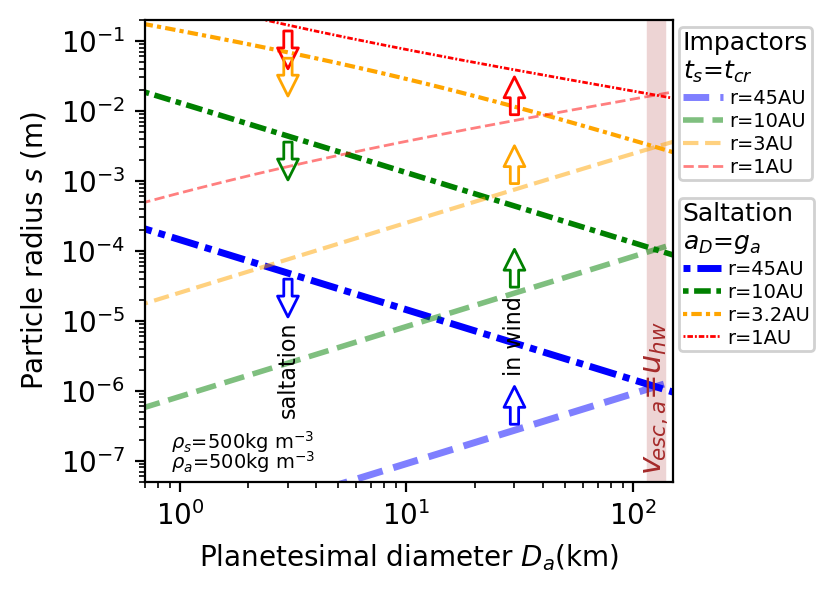

In [216]:
fig,ax =plt.subplots(1,1,figsize=(4,3),dpi=200,facecolor='white')
plt.subplots_adjust(bottom=0.18, top=0.95,left=0.16,right=0.82)
sfac = 1
ax.set_ylim([5.0e-8,0.20])
ax.set_xlim([0.7,150])
ax.set_yscale('log')
ax.set_xscale('log')
if (sfac==1):
    ax.set_ylabel('Particle radius $s$ (m)')
if (sfac==1e3):
    ax.set_ylabel('Particle radius $s$ (mm)')
ax.set_xlabel(r'Planetesimal diameter $D_a$(km)')


# plot splash particles that escape
if (1==0):
    ii =np.logical_and( Dfac >= 1 , sg_45 >0) 
    TS45,=ax.plot(Dkm[ii],sg_45[ii]*sfac,'-',lw=2.5,label=r'r=45AU', \
        color='royalblue',zorder=2) # ls = (0,(2,0.5,4,0.5)))
    ii =np.logical_and( Dfac >= 1 , sg_10 >0) 
    TS10,=ax.plot(Dkm[ii],sg_10[ii]*sfac,'-',lw=2,label=r'r=10AU', \
        color='limegreen',zorder=2) # ls = (0,(2,0.5,3,0.5)))
    ii =np.logical_and( Dfac >= 1 , sg_3 >0) 
    TS3, =ax.plot(Dkm[ii],sg_3[ii]*sfac,'-',lw=1.5,label=r'r=3.2AU', \
        color='goldenrod',zorder=2)  # ls = (0,(2,0.5,2,0.5)))
    ii = np.logical_and(sg_1 > 0,Dfac >1)
    TS1, =ax.plot(Dkm[ii],sg_1[ii]*sfac,'-',lw=1,label=r'r=1AU', \
        color='coral',zorder=2)  # ls = (0,(2,0.5,1,0.5)))
    ttlabel1 = 'Escape' + "\n"+  r'$\tilde t_s$=$\tilde u_{hw}^3/2^\frac{3}{2}$'
    first_legend=ax.legend(handles=[TS45,TS10,TS3,TS1],loc='lower left',fontsize=7,borderpad=0.2,borderaxespad=0.3,\
        handletextpad=0.3,labelspacing=0.2,\
         handlelength=2.0,framealpha=0.9,ncol=1,columnspacing=1,frameon=True,\
          bbox_to_anchor=(1., 0.64),title=ttlabel1,title_fontsize=9,alignment='left')
    ax.add_artist(first_legend)

#ax.plot(0,0,'wo',label=" ",alpha=0.01) # fake label to help with key

# plot saltations 
if (1==1):
    AD45, = ax.plot(Dkm,s_max_45*sfac,lw=2.5,label=r'r=45AU' , color='blue',zorder=2,ls = (0,(1,1,4,1)))
    AD10, = ax.plot(Dkm,s_max_10*sfac,lw=2  ,label=r'r=10AU' , color='green',zorder=2,ls = (0,(1,1,3,1)))
    AD3,  = ax.plot(Dkm,s_max_3*sfac ,lw=1.5,label=r'r=3.2AU', color='orange',zorder=2,ls = (0,(1,1,2.5,1)))
    AD1,  = ax.plot(Dkm,s_max_1*sfac ,lw=1  ,label=r'r=1AU'  , color='red',zorder=2,ls = (0,(0.7,0.7,2,0.7)))
    ttlabel2 = 'Saltation' + "\n"+ r'$a_D$=$g_a$'
    second_legend = ax.legend(handles=[AD45,AD10,AD3,AD1],loc='lower left',fontsize=7,borderpad=0.2,borderaxespad=0.3,\
        handletextpad=0.3,labelspacing=0.2,\
         handlelength=2.0,framealpha=0.9,ncol=1,columnspacing=1,frameon=True,\
          bbox_to_anchor=(1., 0.27),title=ttlabel2,title_fontsize=9,alignment='left')
    ax.add_artist(second_legend)

# plot wind impacting particles, ignoring bondi part 
if (1==1):
    ii = sB_45 > sc_45;  sBc_45 = sc_45; # sBc_45[ii]  = sB_45[ii]
    ii = sB_10 > sc_10;  sBc_10 = sc_10; # sBc_10[ii]  = sB_10[ii]
    ii = sB_3  > sc_3 ;  sBc_3  = sc_3 ; # sBc_3[ii]   = sB_3[ii]
    ii = sB_1  > sc_1 ;  sBc_1  = sc_1 ; # sBc_1[ii]   = sB_1[ii]
    SBC45,=ax.plot(Dkm,sBc_45,'b--',lw=2.5,label='r=45AU',alpha=0.5,zorder=2)
    SBC10,=ax.plot(Dkm,sBc_10,'g--',lw=2,label='r=10AU',alpha=0.5,zorder=2)
    SBC3, =ax.plot(Dkm,sBc_3 ,'--' ,lw=1.5,color='orange',label='r=3AU',alpha=0.5,zorder=2)
    SBC1, =ax.plot(Dkm,sBc_1 ,'r--',lw=1,label='r=1AU',alpha=0.5,zorder=2)
    ttlabel3 ='Impactors' + "\n" +  r'$t_{s}$=$t_{cr}$'
    third_legend = ax.legend(handles=[SBC45,SBC10,SBC3,SBC1],loc='lower left',fontsize=7,borderpad=0.2,borderaxespad=0.3,\
        handletextpad=0.3,labelspacing=0.2,\
         handlelength=2.1,framealpha=0.9,ncol=1,columnspacing=1,frameon=True,\
          bbox_to_anchor=(1., 0.64),title=ttlabel3,title_fontsize=9,alignment='left')
    #ax.add_artist(third_legend) # title=r'$t_{s}$=max[$t_{cr},t_B$]'

# arrows saltation 
if (1==1):
    # x_tail,y_tail then x_head, y_head
    x0=3; dax = 1.; day=0.2;  jj = np.argmin(np.abs(x0-Dkm))
    ax.text(x0,2e-6*sfac,'saltation',va='center',ha='center',fontsize=8,rotation='vertical',zorder=4)
    y0=s_max_1[jj]*sfac; 
    arrow = mpatches.FancyArrowPatch((x0, y0), (x0*dax, y0*day),mutation_scale=15,ec='red',fc='none',zorder=3)
    ax.add_patch(arrow)
    y0=s_max_3[jj]*sfac; 
    arrow = mpatches.FancyArrowPatch((x0, y0), (x0*dax, y0*day),mutation_scale=15,ec='orange',fc='none',zorder=3)
    ax.add_patch(arrow)
    y0=s_max_10[jj]*sfac; 
    arrow = mpatches.FancyArrowPatch((x0, y0), (x0*dax, y0*day),mutation_scale=15,ec='green',fc='none',zorder=3)
    ax.add_patch(arrow)
    y0=s_max_45[jj]*sfac; day=0.2
    arrow = mpatches.FancyArrowPatch((x0, y0), (x0*dax, y0*day),mutation_scale=15,ec='blue',fc='none',zorder=3)
    ax.add_patch(arrow)
    
# arrows in wind
if (1==1):
    x0=30;dax = 1.; day=1/0.2;   jj = np.argmin(np.abs(x0-Dkm))
    ax.text(x0*1,6e-6*sfac,'in wind',va='center',ha='center',fontsize=8,rotation='vertical')
    y0=sBc_1[jj]*sfac;
    arrow = mpatches.FancyArrowPatch((x0, y0), (x0*dax, y0*day),mutation_scale=15,ec='red',fc='none',zorder=3)
    ax.add_patch(arrow)
    y0=sBc_3[jj]*sfac;
    arrow = mpatches.FancyArrowPatch((x0, y0), (x0*dax, y0*day),mutation_scale=15,ec='orange',fc='none',zorder=3)
    ax.add_patch(arrow)
    y0=sBc_10[jj]*sfac;
    arrow = mpatches.FancyArrowPatch((x0, y0), (x0*dax, y0*day),mutation_scale=15,ec='green',fc='none',zorder=3)
    ax.add_patch(arrow)
    y0=sBc_45[jj]*sfac;
    arrow = mpatches.FancyArrowPatch((x0, y0), (x0*dax, y0*day),mutation_scale=15,ec='blue',fc='none',zorder=3)
    ax.add_patch(arrow)

# arrows splash escape
if (1==0):
    x0=30;dax = 1.; day=0.2;   jj = np.argmin(np.abs(x0-Dkm))
    ax.text(x0-2,3e-7*sfac,'splash \n escape',va='center',ha='center',fontsize=10,rotation='vertical')
    y0=sg_1[jj]*sfac;
    arrow = mpatches.FancyArrowPatch((x0, y0), (x0*dax, y0*day),mutation_scale=15,ec='red',fc='none',zorder=3)
    ax.add_patch(arrow)
    y0=sg_3[jj]*sfac;
    arrow = mpatches.FancyArrowPatch((x0, y0), (x0*dax, y0*day),mutation_scale=15,ec='orange',fc='none',zorder=3)
    ax.add_patch(arrow)
    y0=sg_10[jj]*sfac;
    arrow = mpatches.FancyArrowPatch((x0, y0), (x0*dax, y0*day),mutation_scale=15,ec='green',fc='none',zorder=3)
    ax.add_patch(arrow)
    y0=sg_45[jj]*sfac;
    arrow = mpatches.FancyArrowPatch((x0, y0), (x0*dax, y0*day),mutation_scale=15,ec='blue',fc='none',zorder=3)
    ax.add_patch(arrow)

# vertical lines
smin, smax = ax.get_ylim()
y0=smax*1.7
if (1==1):
    ax.plot([D_a_vw/1e3,D_a_vw/1e3], [smin,smax],'-',color='brown',lw=7,alpha=0.2, zorder=1)
    # escape velocity line
    ax.text(D_a_vw/1e3, 0.8e-6*sfac,r'$v_{\!esc,a}$=$u_{hw}$',va='center',ha='center',\
        rotation='vertical',fontsize=11,color='brown')  # its label 
    
if (1==0):  # one third escape velocity line 
    ax.text(D_a_vw/1e3/3, 1.0e-6*sfac,r'$v_{\!esc,a}$=$u_{hw}/3$',va='center',ha='center',\
            rotation='vertical',fontsize=11,color='brown')
    wid = 2*D_a_vw/1e3 /3  # shading rectangle 
    rectangle = mpatches.Rectangle([D_a_vw/1e3/3, smin], wid,smax-smin,alpha=0.2,color='brown' )
    ax.add_patch(rectangle)

# D_erode vertical gray line
if (1==0):
    D_er = D_erode(r,Mmodel,rho_aa,rho_ss)
    ax.plot([D_er/1e3,D_er/1e3], [smin,smax],'-',color='black',lw=5,alpha=0.2, zorder=1)
    ax.text(D_er/1e3*0.94, 3e-4*sfac,r'$D_{erode}$',va='center',ha='center',rotation='vertical',fontsize=12)

Dmin, Dmax = ax.get_xlim()
# horizontal line for pulloff cohesion
if (1==0):
    #ax.plot([D_a_crit2/1e3,Dmax],[s_pull_dust[0],s_pull_dust[0]]*sfac,':',lw=5,alpha=0.5,color='brown')
    CO3, = ax.plot([Dmin,Dmax],[s_pull_dust[1],s_pull_dust[1]]*sfac,'-',lw=5,alpha=0.5,color='gold',zorder=1,\
       label=r'dust,3.2AU')
    #CO10, = ax.plot([Dmin,Dmax],[s_pull_ice[2],s_pull_ice[2]]*sfac,'-',lw=5,alpha=0.3,color='green',zorder=1,\
    #   label=r'ice,10AU')
    #ax.text(1,s_pull_dust[1]*sfac*1.5,r'$F_D$=$F_{coh}$dust,3.2AU',va='center',ha='left',fontsize=10,color='orange' )

    ttlabel4 ='Cohesion' + "\n" +  r'$F_D$=$F_{coh}$'
    fourth_legend = ax.legend(handles=[CO3],loc='lower left',fontsize=7,borderpad=0.2,borderaxespad=0.3,\
        handletextpad=0.5,labelspacing=0.2,\
         handlelength=1.5,framealpha=0.9,ncol=1,columnspacing=1,frameon=True,\
          bbox_to_anchor=(1., 0.0),title=ttlabel4,title_fontsize=9,alignment='left')
    #ax.add_artist(fourth_legend)
    
# some labeling
#ax.text(Dkm[-1]*1.6,s_max_1[-1]*sfac*1.4,'1AU',color='red',ha='right',va='bottom')
#ax.text(Dkm[-1]*1.8,s_max_3[-1]*sfac*0.8,'3.2AU',color='orange',ha='right',va='bottom')
#ax.text(Dkm[-1]*1.8,s_max_10[-1]*sfac*1.9,'10AU',color='green',ha='right',va='bottom')
#ax.text(Dkm[-1]*0.4,s_max_45[-1]*sfac*1.9,'45AU',color='blue',ha='right',va='bottom')

# labelling densities
sastr = r'$\rho_s$' + '={:.0f}'.format(rho_ss) + r'kg m$^{-3}$'
rastr = r'$\rho_a$' + '={:.0f}'.format(rho_aa) + r'kg m$^{-3}$'
ax.text(Dmin*1.3,smin*3.7,sastr,ha='left',va='center',fontsize=7)
ax.text(Dmin*1.3,smin*1.9,rastr,ha='left',va='center',fontsize=7)

plt.savefig('Da_plot.png',dpi=300)

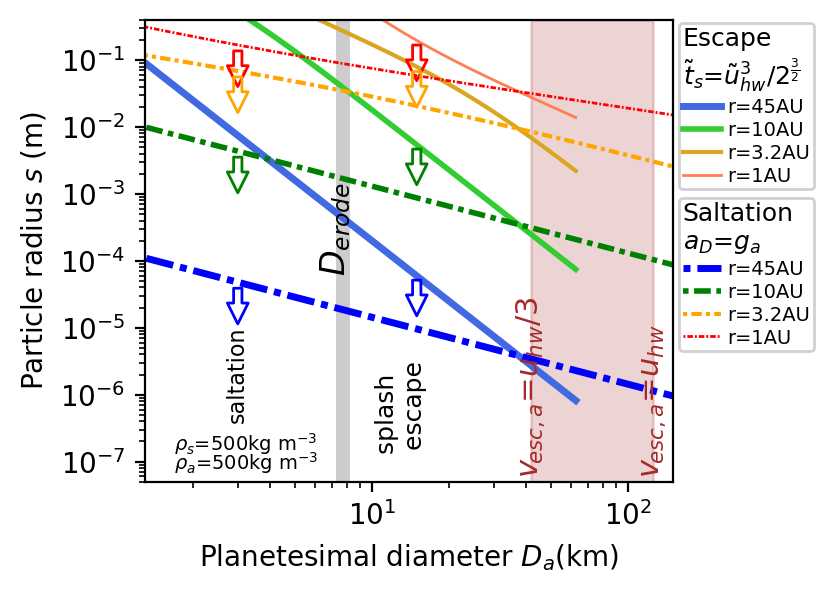

In [225]:
fig,ax =plt.subplots(1,1,figsize=(4,3),dpi=200,facecolor='white')
plt.subplots_adjust(bottom=0.18, top=0.95,left=0.16,right=0.82)
sfac = 1
ax.set_ylim([5.0e-8,0.40])
ax.set_xlim([1.3,150])
ax.set_yscale('log')
ax.set_xscale('log')
if (sfac==1):
    ax.set_ylabel('Particle radius $s$ (m)')
if (sfac==1e3):
    ax.set_ylabel('Particle radius $s$ (mm)')
ax.set_xlabel(r'Planetesimal diameter $D_a$(km)')


# plot splash particles that escape
if (1==1):
    ii =np.logical_and( Dfac >= 1 , sg_45 >0) 
    TS45,=ax.plot(Dkm[ii],sg_45[ii]*sfac,'-',lw=2.5,label=r'r=45AU', \
        color='royalblue',zorder=2) # ls = (0,(2,0.5,4,0.5)))
    ii =np.logical_and( Dfac >= 1 , sg_10 >0) 
    TS10,=ax.plot(Dkm[ii],sg_10[ii]*sfac,'-',lw=2,label=r'r=10AU', \
        color='limegreen',zorder=2) # ls = (0,(2,0.5,3,0.5)))
    ii =np.logical_and( Dfac >= 1 , sg_3 >0) 
    TS3, =ax.plot(Dkm[ii],sg_3[ii]*sfac,'-',lw=1.5,label=r'r=3.2AU', \
        color='goldenrod',zorder=2)  # ls = (0,(2,0.5,2,0.5)))
    ii = np.logical_and(sg_1 > 0,Dfac >1)
    TS1, =ax.plot(Dkm[ii],sg_1[ii]*sfac,'-',lw=1,label=r'r=1AU', \
        color='coral',zorder=2)  # ls = (0,(2,0.5,1,0.5)))
    ttlabel1 = 'Escape' + "\n"+  r'$\tilde t_s$=$\tilde u_{hw}^3/2^\frac{3}{2}$'
    first_legend=ax.legend(handles=[TS45,TS10,TS3,TS1],loc='lower left',fontsize=7,borderpad=0.2,borderaxespad=0.3,\
        handletextpad=0.3,labelspacing=0.2,\
         handlelength=2.0,framealpha=0.9,ncol=1,columnspacing=1,frameon=True,\
          bbox_to_anchor=(1., 0.62),title=ttlabel1,title_fontsize=9,alignment='left')
    ax.add_artist(first_legend)

#ax.plot(0,0,'wo',label=" ",alpha=0.01) # fake label to help with key

# plot saltations 
if (1==1):
    AD45, = ax.plot(Dkm,s_max_45*sfac,lw=2.5,label=r'r=45AU' , color='blue',zorder=2,ls = (0,(1,1,4,1)))
    AD10, = ax.plot(Dkm,s_max_10*sfac,lw=2  ,label=r'r=10AU' , color='green',zorder=2,ls = (0,(1,1,3,1)))
    AD3,  = ax.plot(Dkm,s_max_3*sfac ,lw=1.5,label=r'r=3.2AU', color='orange',zorder=2,ls = (0,(1,1,2.5,1)))
    AD1,  = ax.plot(Dkm,s_max_1*sfac ,lw=1  ,label=r'r=1AU'  , color='red',zorder=2,ls = (0,(0.7,0.7,2,0.7)))
    ttlabel2 = 'Saltation' + "\n"+ r'$a_D$=$g_a$'
    second_legend = ax.legend(handles=[AD45,AD10,AD3,AD1],loc='lower left',fontsize=7,borderpad=0.2,borderaxespad=0.3,\
        handletextpad=0.3,labelspacing=0.2,\
         handlelength=2.0,framealpha=0.9,ncol=1,columnspacing=1,frameon=True,\
          bbox_to_anchor=(1., 0.27),title=ttlabel2,title_fontsize=9,alignment='left')
    #ax.add_artist(second_legend)

# plot wind impacting particles, ignoring bondi part 
if (1==0):
    ii = sB_45 > sc_45;  sBc_45 = sc_45; # sBc_45[ii]  = sB_45[ii]
    ii = sB_10 > sc_10;  sBc_10 = sc_10; # sBc_10[ii]  = sB_10[ii]
    ii = sB_3  > sc_3 ;  sBc_3  = sc_3 ; # sBc_3[ii]   = sB_3[ii]
    ii = sB_1  > sc_1 ;  sBc_1  = sc_1 ; # sBc_1[ii]   = sB_1[ii]
    SBC45,=ax.plot(Dkm,sBc_45,'b--',lw=2.5,label='r=45AU',alpha=0.5,zorder=2)
    SBC10,=ax.plot(Dkm,sBc_10,'g--',lw=2,label='r=10AU',alpha=0.5,zorder=2)
    SBC3, =ax.plot(Dkm,sBc_3 ,'--' ,lw=1.5,color='orange',label='r=3AU',alpha=0.5,zorder=2)
    SBC1, =ax.plot(Dkm,sBc_1 ,'r--',lw=1,label='r=1AU',alpha=0.5,zorder=2)
    ttlabel3 ='Impactors' + "\n" +  r'$t_{s}$=$t_{cr}$'
    third_legend = ax.legend(handles=[SBC45,SBC10,SBC3,SBC1],loc='lower left',fontsize=7,borderpad=0.2,borderaxespad=0.3,\
        handletextpad=0.3,labelspacing=0.2,\
         handlelength=2.1,framealpha=0.9,ncol=1,columnspacing=1,frameon=True,\
          bbox_to_anchor=(1., 0.64),title=ttlabel3,title_fontsize=9,alignment='left')
    #ax.add_artist(third_legend) # title=r'$t_{s}$=max[$t_{cr},t_B$]'

# arrows saltation 
if (1==1):
    # x_tail,y_tail then x_head, y_head
    x0=3; dax = 1.; day=0.2;  jj = np.argmin(np.abs(x0-Dkm))
    ax.text(x0,2e-6*sfac,'saltation',va='center',ha='center',fontsize=8,rotation='vertical',zorder=4)
    y0=s_max_1[jj]*sfac; 
    arrow = mpatches.FancyArrowPatch((x0, y0), (x0*dax, y0*day),mutation_scale=15,ec='red',fc='none',zorder=3)
    ax.add_patch(arrow)
    y0=s_max_3[jj]*sfac; 
    arrow = mpatches.FancyArrowPatch((x0, y0), (x0*dax, y0*day),mutation_scale=15,ec='orange',fc='none',zorder=3)
    ax.add_patch(arrow)
    y0=s_max_10[jj]*sfac; 
    arrow = mpatches.FancyArrowPatch((x0, y0), (x0*dax, y0*day),mutation_scale=15,ec='green',fc='none',zorder=3)
    ax.add_patch(arrow)
    y0=s_max_45[jj]*sfac; day=0.2
    arrow = mpatches.FancyArrowPatch((x0, y0), (x0*dax, y0*day),mutation_scale=15,ec='blue',fc='none',zorder=3)
    ax.add_patch(arrow)
    
# arrows in wind
if (1==0):
    x0=30;dax = 1.; day=1/0.2;   jj = np.argmin(np.abs(x0-Dkm))
    ax.text(x0*1,6e-6*sfac,'in wind',va='center',ha='center',fontsize=8,rotation='vertical')
    y0=sBc_1[jj]*sfac;
    arrow = mpatches.FancyArrowPatch((x0, y0), (x0*dax, y0*day),mutation_scale=15,ec='red',fc='none',zorder=3)
    ax.add_patch(arrow)
    y0=sBc_3[jj]*sfac;
    arrow = mpatches.FancyArrowPatch((x0, y0), (x0*dax, y0*day),mutation_scale=15,ec='orange',fc='none',zorder=3)
    ax.add_patch(arrow)
    y0=sBc_10[jj]*sfac;
    arrow = mpatches.FancyArrowPatch((x0, y0), (x0*dax, y0*day),mutation_scale=15,ec='green',fc='none',zorder=3)
    ax.add_patch(arrow)
    y0=sBc_45[jj]*sfac;
    arrow = mpatches.FancyArrowPatch((x0, y0), (x0*dax, y0*day),mutation_scale=15,ec='blue',fc='none',zorder=3)
    ax.add_patch(arrow)

# arrows splash escape
if (1==1):
    x0=15;dax = 1.; day=0.2;   jj = np.argmin(np.abs(x0-Dkm))
    ax.text(x0-2,6e-7*sfac,'splash \n escape',va='center',ha='center',fontsize=9,rotation='vertical')
    y0=sg_1[jj]*sfac;
    arrow = mpatches.FancyArrowPatch((x0, y0), (x0*dax, y0*day),mutation_scale=15,ec='red',fc='none',zorder=3)
    ax.add_patch(arrow)
    y0=sg_3[jj]*sfac;
    arrow = mpatches.FancyArrowPatch((x0, y0), (x0*dax, y0*day),mutation_scale=15,ec='orange',fc='none',zorder=3)
    ax.add_patch(arrow)
    y0=sg_10[jj]*sfac;
    arrow = mpatches.FancyArrowPatch((x0, y0), (x0*dax, y0*day),mutation_scale=15,ec='green',fc='none',zorder=3)
    ax.add_patch(arrow)
    y0=sg_45[jj]*sfac;
    arrow = mpatches.FancyArrowPatch((x0, y0), (x0*dax, y0*day),mutation_scale=15,ec='blue',fc='none',zorder=3)
    ax.add_patch(arrow)

# vertical lines
smin, smax = ax.get_ylim()
y0=smax*1.7
if (1==1):
    #ax.plot([D_a_vw/1e3,D_a_vw/1e3], [smin,smax],'-',color='brown',lw=7,alpha=0.2, zorder=1)
    # escape velocity line
    ax.text(D_a_vw/1e3, 0.8e-6*sfac,r'$v_{\!esc,a}$=$u_{hw}$',va='center',ha='center',\
        rotation='vertical',fontsize=11,color='brown')  # its label 
    
if (1==1):  # one third escape velocity line 
    ax.text(D_a_vw/1e3/3, 1.3e-6*sfac,r'$v_{\!esc,a}$=$u_{hw}/3$',va='center',ha='center',\
            rotation='vertical',fontsize=11,color='brown')
    wid = 2*D_a_vw/1e3 /3  # shading rectangle 
    rectangle = mpatches.Rectangle([D_a_vw/1e3/3, smin], wid,smax-smin,alpha=0.2,color='brown' )
    ax.add_patch(rectangle)

# D_erode vertical gray line
if (1==1):
    D_er = D_erode(r,Mmodel,rho_aa,rho_ss)
    ax.plot([D_er/1e3,D_er/1e3], [smin,smax],'-',color='black',lw=5,alpha=0.2, zorder=1)
    ax.text(D_er/1e3*0.94, 3e-4*sfac,r'$D_{erode}$',va='center',ha='center',rotation='vertical',fontsize=12)

Dmin, Dmax = ax.get_xlim()
# horizontal line for pulloff cohesion
if (1==0):
    #ax.plot([D_a_crit2/1e3,Dmax],[s_pull_dust[0],s_pull_dust[0]]*sfac,':',lw=5,alpha=0.5,color='brown')
    CO3, = ax.plot([Dmin,Dmax],[s_pull_dust[1],s_pull_dust[1]]*sfac,'-',lw=5,alpha=0.5,color='gold',zorder=1,\
       label=r'dust,3.2AU')
    #CO10, = ax.plot([Dmin,Dmax],[s_pull_ice[2],s_pull_ice[2]]*sfac,'-',lw=5,alpha=0.3,color='green',zorder=1,\
    #   label=r'ice,10AU')
    #ax.text(1,s_pull_dust[1]*sfac*1.5,r'$F_D$=$F_{coh}$dust,3.2AU',va='center',ha='left',fontsize=10,color='orange' )

    ttlabel4 ='Cohesion' + "\n" +  r'$F_D$=$F_{coh}$'
    fourth_legend = ax.legend(handles=[CO3],loc='lower left',fontsize=7,borderpad=0.2,borderaxespad=0.3,\
        handletextpad=0.5,labelspacing=0.2,\
         handlelength=1.5,framealpha=0.9,ncol=1,columnspacing=1,frameon=True,\
          bbox_to_anchor=(1., 0.0),title=ttlabel4,title_fontsize=9,alignment='left')
    #ax.add_artist(fourth_legend)
    
# some labeling
#ax.text(Dkm[-1]*1.6,s_max_1[-1]*sfac*1.4,'1AU',color='red',ha='right',va='bottom')
#ax.text(Dkm[-1]*1.8,s_max_3[-1]*sfac*0.8,'3.2AU',color='orange',ha='right',va='bottom')
#ax.text(Dkm[-1]*1.8,s_max_10[-1]*sfac*1.9,'10AU',color='green',ha='right',va='bottom')
#ax.text(Dkm[-1]*0.4,s_max_45[-1]*sfac*1.9,'45AU',color='blue',ha='right',va='bottom')

# labelling densities
sastr = r'$\rho_s$' + '={:.0f}'.format(rho_ss) + r'kg m$^{-3}$'
rastr = r'$\rho_a$' + '={:.0f}'.format(rho_aa) + r'kg m$^{-3}$'
ax.text(Dmin*1.3,smin*3.7,sastr,ha='left',va='center',fontsize=7)
ax.text(Dmin*1.3,smin*1.9,rastr,ha='left',va='center',fontsize=7)

plt.savefig('Da_plot2.png',dpi=300)



In [75]:
Area_mounds = np.array([13.68,9.32,18.92,28.47,27.19, 22.02, 29.29,45.25,69.23])
errs_mounds = np.array([0.64, 0.59, 0.72, 0.76, 0.70, 0.91, 0.96, 0.79, 0.97])
# From table 1 by Stern+23  but only ones that are not in bold as those are edge-on which have
            #2.88±0.39 , 0.64±0.37  3.81±0.50 
# in km^2
D_area_equiv = np.sqrt(Area_mounds*np.pi/4)
print(D_area_equiv)
print('D_area_equiv {:.1f} km'.format(np.median(D_area_equiv)))

[3.2778418  2.70553338 3.85483245 4.72866638 4.62114445 4.15866175
 4.79628108 5.96148194 7.37381278]
D_area_equiv 4.6 km
